<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 8 (Assignment) -- Introduction to Reinforcement Learning -- Part I </h2>

<h2>Exercise 0</h2>
Before tackling all those exciting tasks of this notebook, the neccessary Python modules need to be loaded. Have a look at the notebook discussed during the lecture, and import the same modules:

In [2]:
import u8_utils as u8
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from typing import Any, Dict, Tuple

# Set Seaborn plotting style.
sns.set()

<h3 style="color:rgb(0,120,170)">Module versions</h3>
As mentioned in the introductiory slides, specific minimum versions of Python itself as well as of used modules is recommended.

In [3]:
u8.check_module_versions()

Installed Python version: 3.7 (✓)
Installed matplotlib version: 3.1.3 (✓)
Installed Pandas version: 1.0.3 (✓)
Installed Seaborn version: 0.10.1 (✓)
Installed OpenAI Gym version: 0.17.2 (✓)


<h2>Exercise 1</h2>

All exercises in this assignment are referring to the <i>FrozenLake-v0</i> environment of <a href="https://gym.openai.com"><i>OpenAI Gym</i></a>. This environment is descibed according to its official <a href="https://gym.openai.com/envs/FrozenLake-v0/">OpenAI Gym website</a> as follows:<br>
<cite>Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.</cite>


There are <i>four</i> types of surfaces described in this environment:
<ul>
    <li><code>S</code> $\rightarrow$ starting point (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>F</code> $\rightarrow$ frozen surface (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>H</code> $\rightarrow$ hole (<span style="color:rgb(255,0,0)"><i>fall to your doom</i></span>)</li>
    <li><code>G</code> $\rightarrow$ goal (<span style="color:rgb(255,0,255)"><i>frisbee location</i></span>)</li>
</ul>


If not already done, more information on how to <i>install</i> and <i>import</i> the <code>gym</code> module is available in the lecture's notebook.

In [4]:
import gym

from gym.envs.toy_text import FrozenLakeEnv # environment similar


<h3 style="color:rgb(0,120,170)">States and actions</h3>
Experiment with the <i>FrozenLake-v0</i> environment as discussed during the lecture and explained in the accompanying notebook.
<ul>
    <li>Create a <i>FrozenLake</i> environment with either a call to the constructor <code>FrozenLakeEnv()</code> or via a general factory function <code>gym.make(r'FrozenLake-v0').env</code>.
    <li>For reproducability reasons, always set the <i>random seed</i> if working with randomness (like drawing from a distribution using a pseudo random number generator). The <code>u8_utils.py</code> file provides a neat helper function <code>set_seed</code> for this very purpose.</li>
</ul>

In [5]:
lake = FrozenLakeEnv()
u8.set_seed(environment=lake, seed=42)


As a next step, and as the environment might be unknown to some, visualise the current state.
<ul>
    <li>Visualise the current <i>FrozenLake</i> environment in a human-readable way.</li>
    <li>Print the identifier of the current state using the appropriate property of the environment.</li>
</ul>

In [6]:
lake.render(mode=r'human')
current_state_id = lake.s
print(f'Current state ID: {current_state_id}')



SFFF
FHFH
FFFH
HFFG
Current state ID: 0


The current position of the <i>disc retrieving</i> entity is displayed as a filled <span style="color:rgb(255,0,0)"><i>red</i></span> rectangle.

As we want to tackle this problem using our renowned <i>random search</i> approach, we have to analyse its applicability beforehand. Hence, the number of possible <i>actions</i> and <i>states</i> is of utter importance, as we don't want to get lost in the depth of combinatorial explosion.
<ul>
    <li>Query the amount of <i>actions</i> using the appropriate peoperty of the lake environment.</li>
    <li>Query the amount of <i>states</i> using the appropriate property of the lake environment.</li>
</ul>

In [7]:
num_actions = lake.action_space.n
num_states = lake.observation_space.n
print(f'The FrozenLake-v0 environment comprises <{num_actions}> actions and <{num_states}> states.')


The FrozenLake-v0 environment comprises <4> actions and <16> states.


<h3 style="color:rgb(0,120,170)">Rewards</h3>
Remember that each <i>action</i> triggers a <i>reaction</i> (at least in the domain of Reinforcement Learning), in this case in the form of a <i>reward</i> or a <i>penalty</i>. As the definition of both, the former as well as the latter would be redundant, only the former is kept, the <i>reward</i>. The latter, the <i>penalty</i>, is simply a <i>negative reward</i>. According to the description of the <a href=https://gym.openai.com/envs/FrozenLake-v0/>environment's website</a>:<br><br>
<cite>The episode ends when you reach the goal or fall in a hole. You receive a reward of $1$ if you reach the goal, and zero otherwise.</cite><br><br>
Hence in the current setting, only <i>non-negative</i> rewards are issued, and <i>no</i> penalty per se. The goal of our <i>agent</i> is to maximise the reward by still solving the task. in this setting, this would translate to the following premises:
<ul>
    <li>Reach the goal (i.e. pickup the frisbee).</li>
    <li>Do not undertake involuntary dives.</li>
    <li>Try to keep some distance to holes, as the ice is slippery.</li>
</ul>

The mapping <i>state</i>$\rightarrow$<i>action</i> for all possible combinations of <i>state</i> and <i>actions</i> is defined in a <i>reward table</i>. Investigate the reward tablewith respect to the <i>current state</i> of our instantiated <i>FrozenLake</i> environment.

In [8]:
lake.P[current_state_id]


{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

Each entry of the <i>reward table</i> contains a dictionary of the form <code>A: [3 x (B, C, D, E)]</code>.

<h3 style="color:rgb(208,90,80)">Tasks</h3>

<ul>
    <li><span style="color:rgb(208,90,80)">Think about the different <i>actions</i>. Which ones might be available?</span></li>
    <li><span style="color:rgb(208,90,80)">Think about the different <i>states</i>. Which ones might be possible?</span></li>
    <li><span style="color:rgb(208,90,80)">Think about the structure of the <i>reward table</i>. Why are there <i>three</i> elements per dictionary entry, instead of <i>one</i> like the <i>Taxi</i> environment defined?</span></li>
</ul>

Think about the different actions. Which ones might be available? <br>
4 possible actions:<br>
move south <br>
move north <br>
move east <br>
move west <br>

Think about the different states. Which ones might be possible?
16 states possible. <br>
The array/lake has a height of 4 and and width of 4. --> a size of 16. There are 16 possible current locations of
the person on the lake. These current locations are the possible states.

Think about the structure of the reward table. Why are there three elements per dictionary entry, instead of one like the Taxi environment defined? <br>
On the lake environment is only 1/3 probability that the wanted action is also done. There are also other possible consequences of the order of a special action (probability 2/3). That is because of the slippery ice. You cannot always move in the direction you wanted to move. In the Taxi environment you always move in the direction you want to move. So, there is a probability of 1 that wanted_move == realized_move. In conclusion, one dictionary entry is enough for the taxi environment because the "B" describes the probability for wanted_move == realized_move.


<h2>Exercise 2</h2>

Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i>: using <i>random search</i>. In the meantime we analysed the <i>action</i> as well as the <i>state space</i> and came to the conclusion, that such an approach is more than feasible. To repeat the outline of such an approach:
<ul>
    <li><code>I</code> $\rightarrow$ choose a random <i>action</i> with respect to the <i>current</i> state.</li>
    <li><code>II</code> $\rightarrow$ execute previously chosen <i>action</i> and transition into a <i>new</i> state.</li>
    <li><code>III</code> $\rightarrow$ if the episode is finished, but the goal not reached, <i>reset</i> the position of the <i>disc retrieving entity</i>.</li>
</ul>

This procedure is repeated as long as the task is not solved or a defined maximum of steps is reached, whatever triggers first (<code>IV</code>). Adapt the function <code>apply_random_search</code> as discussed during the lecture. Mark the corresponding sections of the code using <code>I</code>, <code>II</code>, <code>III</code> and <code>IV</code>. Note that our <i>random search</i> is <i>not</i> guaranteed to find  the solution of a task in <i>finite time</i>, hence an upper border on the <i>runtime</i> is often applied as a safety net (in our case the <i>number of allowed steps</i>).

In [37]:
def apply_random_search(max_steps, environment: FrozenLakeEnv) -> Tuple[int, int, int, Dict[str, Any]]:
    """
    Solve specified environment by applying random search.
    
    :return: amount of steps performed, penalties inflicted, final reward and captured frames
    """
    num_steps, num_penalties, final_reward = 0, 0, 0
    captured_frames = []

    # <IV>: repeat the goal search until task solved
    done = False
    while not done and num_steps < max_steps: # <IV>: When this maximum number of steps is overrun then stop the procedure   
       
        # <I>: choose a random action with respect to the current state.
        current_action = environment.action_space.sample()

        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, done, info = environment.step(current_action)


        # <III>: episode ends but not successfully (no goal):
        if done and current_reward == 0.0:
            num_penalties += 1
            lake.reset()

        # <IV>: When the goal is found you can end the search
        if current_reward == 1.0:
            final_reward += current_reward
        
        num_steps += 1
        done = current_reward == 1.0 and done
        
        # Save rendering of current state.
        captured_frames.append({
            r'frame': environment.render(mode=r'ansi'),
            r'state': current_state,
            r'action': current_action,
            r'reward': current_reward
        })

    return num_steps, num_penalties, final_reward, captured_frames

Now everything is setup and the <i>random search</i> procedure is eagerly waiting to explore the exciting world of <i>FrozenLake-v0</i> (the <i>Taxi-v3</i> world was a less exciting than thought)!
<ul>
    <li>Again for reproducability reasons, the <i>random seed</i> is set, in this case to $42$. The <code>u8_utils.py</code> file provides a neat helper function <code>set_seed</code> for this very purpose.</li>
    <li>To actually start the random search, the previously defined function <code>apply_random_search</code> is of great help.</li>
    <li>At least randomly search for $10\ 000$ steps.</li>
</ul>

To get a better feeling about the <i>exploration</i>, we're reporting the amount of steps performed as well as the amount of involuntary dives. Let's get excited!

In [38]:
u8.set_seed(environment=lake, seed=42)
num_steps, num_penalties, final_reward, captured_frames = apply_random_search(10000, environment=lake)

print(f'{num_steps} steps taken and {num_penalties} penalty/penalties inflicted during randomly searching the goal, with a final reward of {final_reward}.')


260 steps taken and 32 penalty/penalties inflicted during randomly searching the goal, with a final reward of 1.0.


Actually, the result looks quite good, especially when comparing it with the random searches conducted in the <i>Taxi</i> environment. Let's animate the searching procedure (use a <code>delay</code> of $0.1$ for better visualisation):

In [39]:
u8.animate_environment_search(frames=captured_frames, verbose=True, delay=0.1)


  (Right)
SFFF
FHFH
FFFH
HFFG

Step No.: 260
State ID: 15
Action ID: 2
Reward: 1.0


<h3 style="color:rgb(208,90,80)">Tasks</h3>

<ul>
    <li><span style="color:rgb(208,90,80)">Why is the result of randomly searching the <i>FrozenLake-v0</i> environment by far better than randomly searching the <i>Taxi</i> environment?</span></li>
    <li><span style="color:rgb(208,90,80)">Are the results transferable to <i>bigger</i> lakes? Argument your answer.</span></li>
</ul>

Why is the result of randomly searching the FrozenLake-v0 environment by far better than randomly searching the Taxi environment? <br>
For the FrozenLake-v0 environment are less possible states (16) whereas the Taxi environment has 500 possible states. Furthermore, the task of FrozenLake-v0 environment is easier because you only have to reach the goal and don't fall into the water. In the Taxi environment the task is more complex. You have to drive to a person and take him/her and let him/her out at the correct position and nowhere else. 

Are the results transferable to bigger lakes? Argument your answer.<br>
When you have a bigger lake you also have more possible states and eventually more holes but the goal will be only one. So, there are more barriers on your way to the goal and you need longer to search because of the more possible states/positions. Therefore, the results wouldn't be for the big lake as good as for the 4x4 lake. However, the states don't become that big, ?x? (field big lake) - 4x4 (field old lake) = new_additional_states. It follows that the number of states doesn't increase that dramatically. Therefore, the results for both lakes don't distinguish extremely. Therefore, the results of the small lake are more or less transferable to the big lake (but on the small lake at least a bit better).

<h2>Exercise 2</h2>

To drill down on the drawbacks of plain <i>random search</i>, we are designing the following experimental setup:
<ul>
    <li>Repeat the previous <i>random search</i> procedure $100$ times.</li>
    <li>Aggregate the results of each run for later analysis.</li>
    <li>Visualise the aggegrated results using e.g. <i>box-</i> and <i>swarm-plots</i>.</li>
</ul>
Once again, we are setting the <i>random seed</i>, but take care of setting it <i>outside</i> the loop, otherwise the same result is reported with each iteration (and an aggregation of the results would not give us any more insights).

In [70]:
u8.set_seed(environment=lake, seed=42)
num_steps_total, num_penalties_total, final_reward_total = [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    num_steps, num_penalties, final_reward, _ = apply_random_search(10000, environment=lake)
    num_steps_total.append(num_steps)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame(zip(
    num_steps_total, num_penalties_total, final_reward_total
), columns=(r'Steps performed', r'Holes/Fails', r'Final reward'))


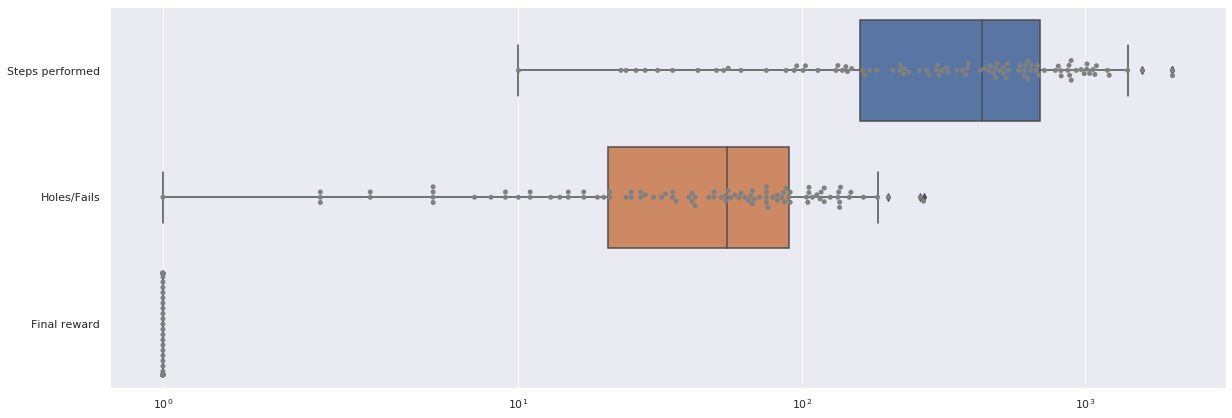

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(20, 7))
ax[0, 0].set_xscale(r'symlog')
_ = sns.boxplot(data=collected_experiment_info, ax=ax[0, 0], orient=r'h')
_ = sns.swarmplot(data=collected_experiment_info, ax=ax[0, 0], color=r'0.5', orient=r'h')


<h3 style="color:rgb(208,90,80)">Tasks</h3>

<ul>
    <li><span style="color:rgb(208,90,80)">Try out different <code>maximal steps</code> and <code>initial seeds</code> (still repeating the random search procedure $100$ times). Do the results differ?</span></li>
    <li><span style="color:rgb(208,90,80)">Which kind of information could a potential <i>Reinforcement Learning</i> method incorporate?</span></li>
</ul>

Try out different maximal steps and initial seeds (still repeating the random search procedure 100 times). Do the results differ?<br>
By less steps the fails are higher than for more steps because by manys steps you can try more often to find the goal. When you change the seed the number of fails can increase or decrease. 

Which kind of information could a potential Reinforcement Learning method incorporate? <br>
The reward of 1 when you reach the goal leads to the fact that AI can learn to search for the goal. The actions "jump into one hole" or "go at the near of the hole and then fall into hole because of slippery ice" would lead to an end of the game with a final reward of 0. However, AI wants to reach a final reward of 1 which is only possible by achieving the goal. Therefore, the AI will learn not to go in the near of the holes when possible and not jumping into a hole. --> reward incorporates the Reinforcement Learning.